In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from utils import *
import copy
import math

### Loading and visualizing the data

In [5]:
features = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted',
            'num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds',
            'is_host_login',
            'is_guest_login',
            'count',
            'srv_count',
            'serror_rate',
            'srv_serror_rate',
            'rerror_rate',
            'srv_rerror_rate',
            'same_srv_rate',
            'diff_srv_rate',
            'srv_diff_host_rate',
            'dst_host_count',
            'dst_host_srv_count',
            'dst_host_same_srv_rate',
            'dst_host_diff_srv_rate',
            'dst_host_same_src_port_rate',
            'dst_host_srv_diff_host_rate',
            'dst_host_serror_rate',
            'dst_host_srv_serror_rate',
            'dst_host_rerror_rate',
            'dst_host_srv_rerror_rate',
            'intrusion_type']

In [39]:
data = pd.read_csv("dataset/kddcup.data_10_percent_corrected", names=features, header=None)
# Perform one-hot encoding for the categorical columns (protocol, service, flag)
encoded_data = pd.get_dummies(data, columns=['protocol_type', 'service', 'flag'], dtype=int)
# Move the one-hot encoded columns before the last element in each row
last_element_column = data.columns[-1]
encoded_data = encoded_data[[col for col in encoded_data.columns if col != last_element_column] + [last_element_column]]
# encoded_data = encoded_data.replace({False:0, True:1})
print(data.shape)
data.head()
#.iloc indexer in pandas to select all rows (:) and all columns except the last one (:-1)
x_train = encoded_data.iloc[:,:-1].values
y_train = np.array([1 if label != 'normal.' else 0 for label in data['intrusion_type']])

(494021, 42)


In [58]:
print("First five elements in X_train are:\n", x_train[:1])
print("Type of X_train:",type(x_train))

First five elements in X_train are:
 [[0.00e+00 1.81e+02 5.45e+03 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 8.00e+00 8.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 1.00e+00 0.00e+00 0.00e+00 9.00e+00 9.00e+00 1.00e+00 0.00e+00
  1.10e-01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 

In [41]:
print("First five elements in y_train are:\n", y_train[:5])
print("Type of y_train:",type(y_train))

First five elements in y_train are:
 [0 0 0 0 0]
Type of y_train: <class 'numpy.ndarray'>


In [67]:
intrusion_label = set(data['intrusion_type'].values)
print(intrusion_label)

{'land.', 'guess_passwd.', 'imap.', 'teardrop.', 'warezmaster.', 'ftp_write.', 'buffer_overflow.', 'pod.', 'portsweep.', 'normal.', 'warezclient.', 'ipsweep.', 'loadmodule.', 'satan.', 'neptune.', 'smurf.', 'multihop.', 'rootkit.', 'back.', 'nmap.', 'spy.', 'perl.', 'phf.'}


In [68]:
#Check for duplicates
data.drop_duplicates(subset=features, keep='first', inplace=True)
data.shape
#Check for null

(145586, 42)

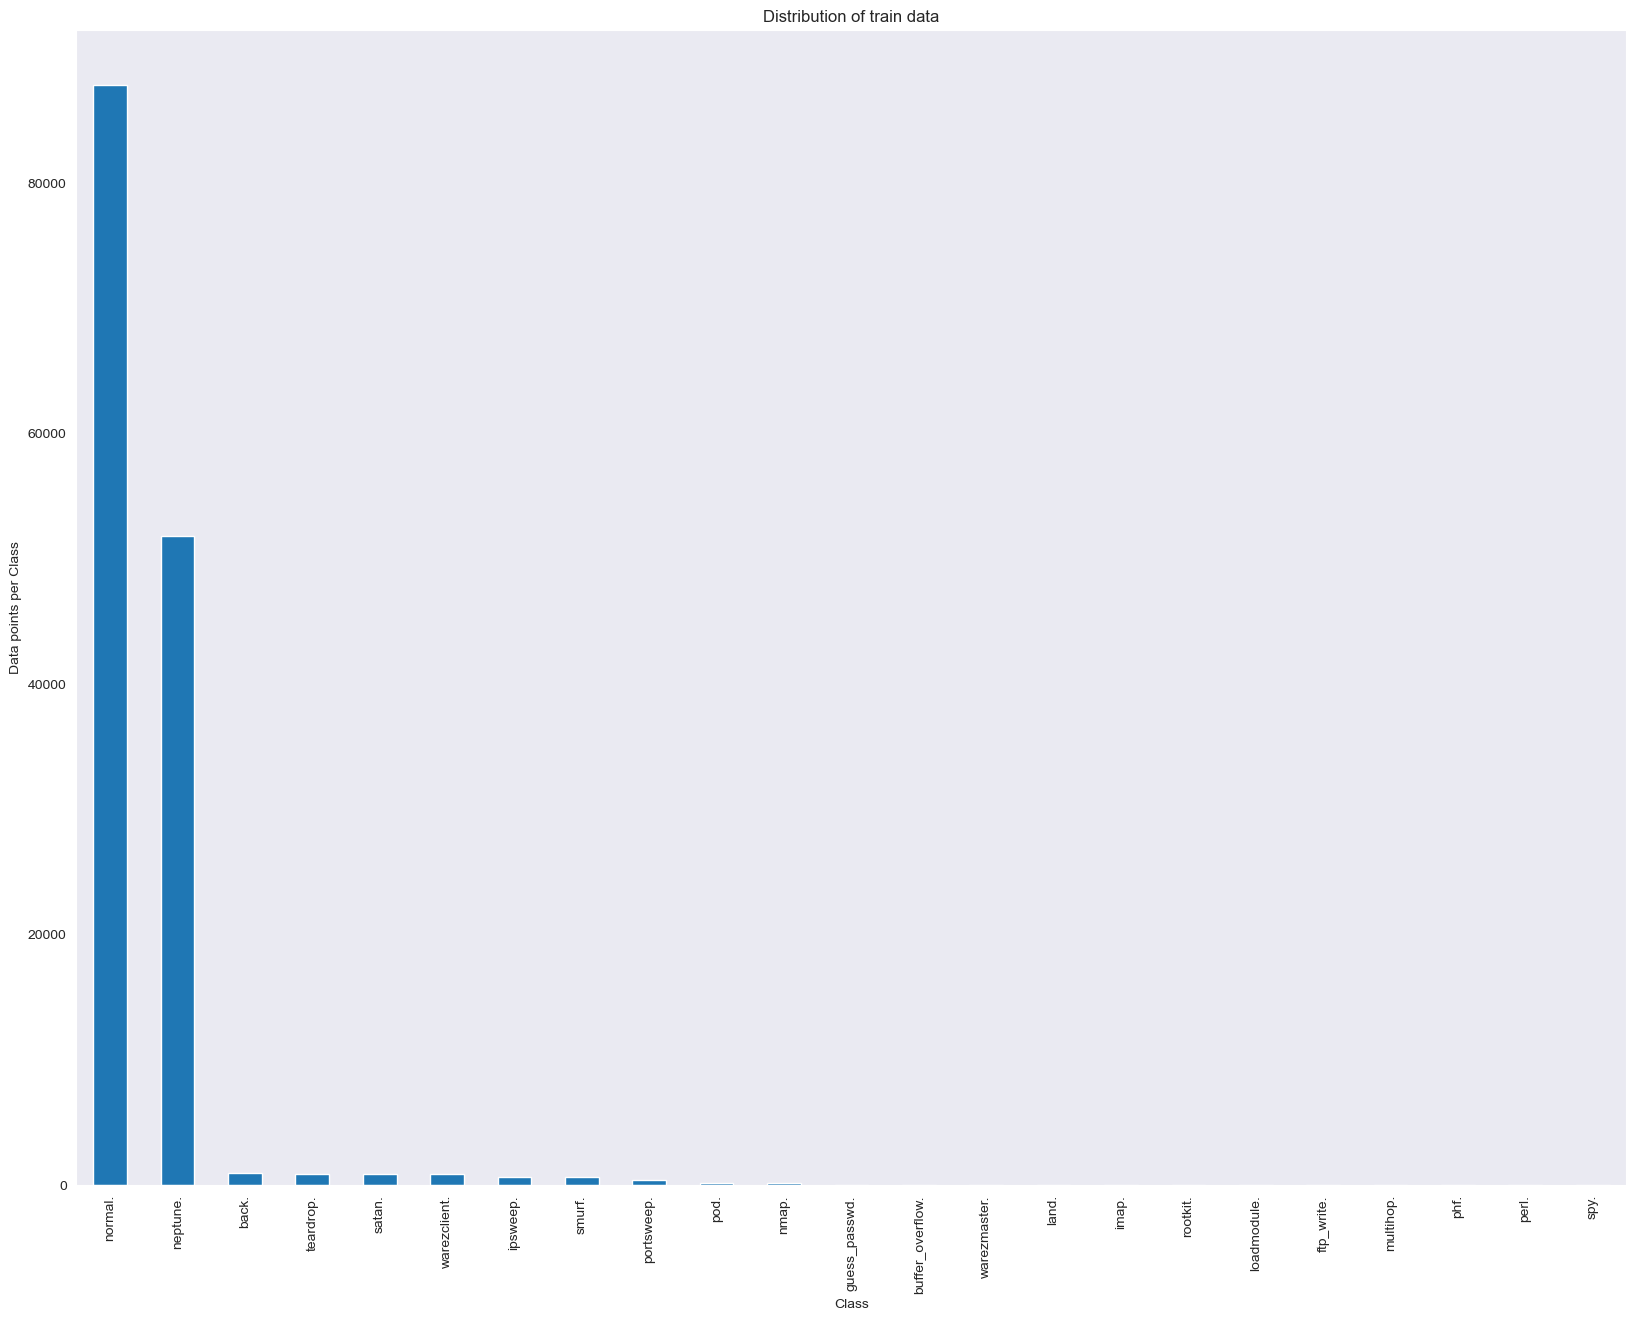

In [59]:
#Visualize data
plt.figure(figsize=(20,15))
class_distribution = data['intrusion_type'].value_counts()
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of train data')
plt.grid()
plt.show()

### Sigmoid function

In [47]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Args:
        z (ndarray): A scalar, numpy array, or list of any size.

    Returns:
        g (ndarray): sigmoid(z), with the same shape as z
    """
    if isinstance(z, (int,float)):
        z = [z]
    
    g = [1/ (1 + np.exp(-z_i)) for z_i in z]
    
    return g

### Cost function for logistic regression
Recall that for logistic regression, the cost function is of the form:

$$
J(\mathbf{w},b) = \frac{1}{m}\sum_{i=0}^{m-1} \left[ \text{loss}(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) \right] \tag{1}
$$

Where:
* $m$ is the number of training examples in the dataset.

* $\text{loss}(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)})$ is the cost for a single data point, which is given by:

    $$
    \text{loss}(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) = (-y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \tag{2}
    $$

* $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$ represents the actual label.

* $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = g(\mathbf{w} \cdot \mathbf{x^{(i)}} + b)$, where the function $g$ is the sigmoid function.

    * It might be helpful to first calculate an intermediate variable $z_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x^{(i)}} + b = w_0x^{(i)}_0 + ... + w_{n-1}x^{(i)}_{n-1} + b$, where $n$ is the number of features, before calculating $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = g(z_{\mathbf{w},b}(\mathbf{x}^{(i)}))$.

Note:
* As you are doing this, remember that the variables `X_train` and `y_train` are not scalar values but matrices of shape ($m, n$) and ($m$, 1), respectively, where $n$ is the number of features and $m$ is the number of training examples.
* You can use the sigmoid function that you implemented above for this part.


In [48]:
def compute_cost(X,y,w,b, *argv):
    m, n = X.shape
    #Calculate the intermediate value first
    #[x_0 * w + b, x_1 * w + b, x_2 * w + b.......]
    z_x = np.dot(X,w) + b
    #f_{w,b}(x^i) => [sig(x_0 * w + b), sig(x_1 * w + b), sig(x_2 * w + b).......]
    f_x = sigmoid(z_x)
    #loss
    loss = [-y_i*np.log(f_x_i) - (1-y_i)*np.log(1-f_x_i) for f_x_i, y_i in zip(f_x, y)]
    #sum of the total cost
    total_cost = 1/m * sum(loss)
    return total_cost

### Gradient for logistic regression

\begin{align*}
& \text{repeat until convergence:} \{ \\
& \quad b := b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b} \\
& \quad w_j := w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{1} \\
& \quad \text{for j := 0..n-1} \\
& \}
\end{align*}

where, parameters $b$, $w_j$ are all updated simultaniously.

The partial derivatives of the cost function $J(\mathbf{w},b)$ with respect to the parameters are given by:

$$
\frac{\partial J(\mathbf{w},b)}{\partial b}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)}) \tag{2}
$$

$$
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)})x_{j}^{(i)} \tag{3}
$$

Where:
* $m$ is the number of training examples in the dataset.
* $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ represents the model's prediction for example $\mathbf{x}^{(i)}$, and $\mathbf{y}^{(i)}$ is the actual label.

In [49]:
def compute_gradient(X, y, w, b, lambda_=None):
    """
    Computes the gradient for logistic regression 
 
    Args:
      X : (ndarray Shape (m,n)) variable such as house size 
      y : (array_like Shape (m,1)) actual value 
      w : (array_like Shape (n,1)) values of parameters of the model      
      b : (scalar)                 value of parameter of the model 
      lambda_: unused placeholder.
    Returns
      dj_dw: (array_like Shape (n,1)) The gradient of the cost w.r.t. the parameters w. 
      dj_db: (scalar)                The gradient of the cost w.r.t. the parameter b. 
    """
    m, n = X.shape
    dj_db = 0.
    dj_dw = np.zeros(w.shape)
    
    
    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i], w) + b)
        err_i = f_wb_i - y[i]
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err_i * X[i,j]
        dj_db = dj_db + err_i
    dj_dw = dj_dw/m
    dj_db = dj_db/m
    
    return dj_db, dj_dw

### Learning parameters using gradient descent

In [50]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_):
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X :    (array_like Shape (m, n)
      y :    (array_like Shape (m,))
      w_in : (array_like Shape (n,))  Initial values of parameters of the model
      b_in : (scalar)                 Initial value of parameter of the model
      cost_function:                  function to compute cost
      alpha : (float)                 Learning rate
      num_iters : (int)               number of iterations to run gradient descent
      lambda_ (scalar, float)         regularization constant
      
    Returns:
      w : (array_like Shape (n,)) Updated values of parameters of the model after
          running gradient descent
      b : (scalar)                Updated value of parameter of the model after
          running gradient descent
    """

    # number of training examples
    m = len(X)

    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w_history = []

    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)

        # Update Parameters using w, b, alpha and gradient
        w_in = w_in - alpha * dj_dw
        b_in = b_in - alpha * dj_db

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            cost =  cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")

    return w_in, b_in, J_history, w_history #return w and J,w history for graphing

Now let's run the gradient descent algorithm above to learn the parameters for our dataset.

**Note**

The code block below takes a couple of minutes to run, especially with a non-vectorized version. You can reduce the `iterations` to test your implementation and iterate faster. If you have time, try running 100,000 iterations for better results.

In [61]:
np.random.seed(1)
initial_w = 0.01 * (np.random.rand(118) - 0.5)
initial_b = -8

# Gradient descent settings
iterations = 10000
alpha = 0.001
w,b, J_history, _ = gradient_descent(x_train, y_train, initial_w, initial_b, compute_cost, compute_gradient, alpha, iterations, 0)

/var/folders/tm/rbrm8zcn031_jl_x_sk0v6440000gn/T/ipykernel_2153/2996302235.py:14: RuntimeWarning: overflow encountered in exp
  g = [1/ (1 + np.exp(-z_i)) for z_i in z]
/var/folders/tm/rbrm8zcn031_jl_x_sk0v6440000gn/T/ipykernel_2153/356144644.py:9: RuntimeWarning: divide by zero encountered in log
  loss = [-y_i*np.log(f_x_i) - (1-y_i)*np.log(1-f_x_i) for f_x_i, y_i in zip(f_x, y)]
/var/folders/tm/rbrm8zcn031_jl_x_sk0v6440000gn/T/ipykernel_2153/356144644.py:9: RuntimeWarning: invalid value encountered in scalar multiply
  loss = [-y_i*np.log(f_x_i) - (1-y_i)*np.log(1-f_x_i) for f_x_i, y_i in zip(f_x, y)]


Iteration    0: Cost      nan   


KeyboardInterrupt: 